In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

In [4]:
base_dir = os.getcwd()

fotos_dir = os.path.join(base_dir, 'Fotos')

In [6]:
rus = pd.read_pickle('rus_agg_con_categorias_y_fotos_sa.p')


# rus = rus.head(1000)

print('Cantidad de fotos', len(rus))



# 

Cantidad de fotos 1928


In [7]:
rus.sample(3)

,index,SMP,Oficinas,Lote,Público,Industrial,Comercial-Servicios,Estacionamiento,Abandonado-Obra,Departamentos,Casa-PH,Categoria,web_ciudad,file,filename,hay_foto
369,7393,006-047-022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Casa-PH,http://fotos.usig.buenosaires.gob.ar//getFoto?...,006-047-022.jpg,C:\Users\maxir\Artificial Intelligence\Desafio...,1
1530,24626,015-003-040,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"Departamentos, Estacionamiento",http://fotos.usig.buenosaires.gob.ar//getFoto?...,015-003-040.jpg,C:\Users\maxir\Artificial Intelligence\Desafio...,1
863,14856,010-057-003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Casa-PH,http://fotos.usig.buenosaires.gob.ar//getFoto?...,010-057-003.jpg,C:\Users\maxir\Artificial Intelligence\Desafio...,1


In [9]:
rus.shape[0]

1928

Levanto las imágenes y las convierto en un vector

In [10]:
img_width = 350
img_height = 350
X = []
for i in tqdm(range(0,rus.shape[0])):
  path = os.path.join(os.getcwd(),'Fotos',rus['file'][i])

  try:
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)
    rus.loc[i, 'file_valida'] = 1
  except:
    rus.loc[i, 'file_valida'] = 0

X = np.array(X)
rus = rus[rus.file_valida == 1].reset_index(drop=True) 
X.shape


100%|█████████████████████████████████████████████████████████████████████████████| 1928/1928 [00:16<00:00, 116.03it/s]


(1928, 350, 350, 3)

Casa-PH, Estacionamiento


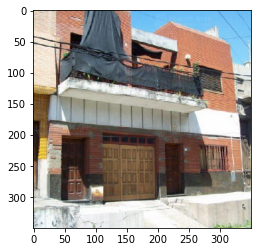

In [11]:
nimg = rus.sample(1).index.values[0]
print(rus['Categoria'][nimg])
plt.imshow(X[nimg])


In [12]:
rus.columns

Index(['index', 'SMP', 'Oficinas', 'Lote', 'Público', 'Industrial',
       'Comercial-Servicios', 'Estacionamiento', 'Abandonado-Obra',
       'Departamentos', 'Casa-PH', 'Categoria', 'web_ciudad', 'file',
       'filename', 'hay_foto', 'file_valida'],
      dtype='object')

In [13]:
y = rus[['Casa-PH', 'Departamentos', 'Comercial-Servicios', 'Estacionamiento']]
y = y.to_numpy()
y.shape



(1928, 4)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.15)


Crear Modelo CNN

In [15]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation='sigmoid'))  # primer parámetro es cantidad de categorías



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 348, 348, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 348, 348, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 174, 174, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 174, 174, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 172, 172, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 172, 172, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 86, 32)        0

In [16]:
miou = tf.keras.metrics.MeanIoU(num_classes=4)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[miou])


In [18]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Train on 1638 samples, validate on 290 samples
Epoch 1/15
1638/1638 [==============================] - 49s 30ms/sample - loss: 0.9022 - mean_io_u: 0.2846 - val_loss: 4.1355 - val_mean_io_u: 0.2810
Epoch 2/15
1638/1638 [==============================] - 29s 18ms/sample - loss: 0.7555 - mean_io_u: 0.2846 - val_loss: 5.8768 - val_mean_io_u: 0.3026
Epoch 3/15
1638/1638 [==============================] - 30s 19ms/sample - loss: 0.6934 - mean_io_u: 0.2846 - val_loss: 11.9377 - val_mean_io_u: 0.3515
Epoch 4/15
1638/1638 [==============================] - 37s 23ms/sample - loss: 0.6525 - mean_io_u: 0.2846 - val_loss: 14.4389 - val_mean_io_u: 0.3743
Epoch 5/15
1638/1638 [==============================] - 29s 17ms/sample - loss: 0.6205 - mean_io_u: 0.2846 - val_loss: 6.5130 - val_mean_io_u: 0.3014
Epoch 6/15
1638/1638 [==============================] - 31s 19ms/sample - loss: 0.5821 - mean_io_u: 0.2846 - val_loss: 10.5011 - val_mean_io_u: 0.3523
Epoch 7/15
1638/1638 [============================

In [29]:
def plot_history(name, history, legend, plot_val=True):
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle(name)
    
    if not isinstance(history, list):
        history = [history]
        
    for h in history:
        acc = h.history['mean_io_u']
        loss = h.history['loss']
        if plot_val:
            val_loss = h.history['val_loss']
            val_acc = h.history['val_mean_io_u']
        epochs = range(1, len(acc) + 1)

        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        lb, ub = ax[0].get_xlim( )
        ax[0].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[0].set_ylim([0, 1])
        ax[0].set_yticks( np.linspace(0, 1, 6 ) )
        ax[0].set_ylabel('Loss')
        
        ax[0].plot(epochs, loss)
        if plot_val:
            ax[0].plot(epochs, val_loss)
            
        ax[1].set_title('MeanIoU')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        lb, ub = ax[1].get_xlim( )
        ax[1].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks( np.linspace(0, 1, 6 ) )
        ax[1].set_ylabel('MeanIoU')
        ax[1].plot(epochs, acc)
        
        if plot_val:
            ax[1].plot(epochs, val_acc)
        
    ax[0].legend([l+' loss' for l in legend])
    ax[1].legend([l+' MeanIoU' for l in legend])

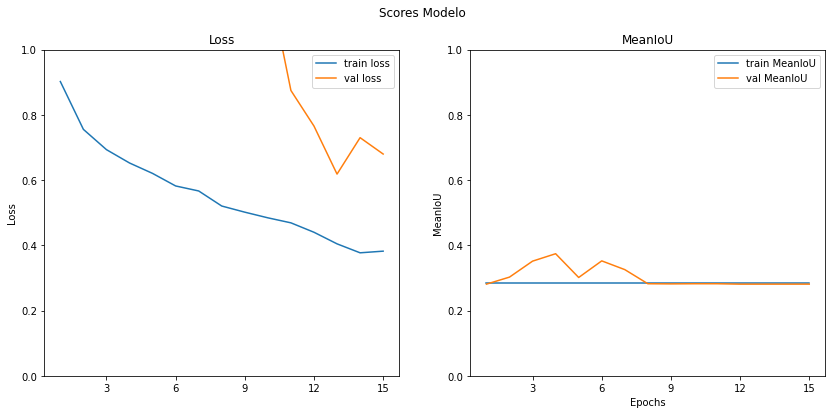

In [30]:
plot_history('Scores Modelo', history, ['train', 'val'])

Transfer Learning

In [21]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(350, 350, 3))

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 350, 350, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 350, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 350, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 175, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 175, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 175, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 87, 128)       0     

In [25]:
X_train[0].shape

(350, 350, 3)

In [26]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_shape = X_train[0].shape))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Flatten())
model.add(layers.Dense(4, activation='sigmoid'))








In [27]:
conv_base.trainable = False

In [28]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=[miou])

history2 = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=20,
                    validation_data=(X_test, y_test))

Train on 1638 samples, validate on 290 samples
Epoch 1/15
1638/1638 [==============================] - 33s 20ms/sample - loss: 0.7420 - mean_io_u: 0.2846 - val_loss: 0.7047 - val_mean_io_u: 0.2810
Epoch 2/15
1638/1638 [==============================] - 25s 15ms/sample - loss: 0.5617 - mean_io_u: 0.2846 - val_loss: 0.6784 - val_mean_io_u: 0.2810
Epoch 3/15
1638/1638 [==============================] - 25s 15ms/sample - loss: 0.4716 - mean_io_u: 0.2846 - val_loss: 0.6128 - val_mean_io_u: 0.2810
Epoch 4/15
1638/1638 [==============================] - 26s 16ms/sample - loss: 0.4056 - mean_io_u: 0.2846 - val_loss: 0.6030 - val_mean_io_u: 0.2810
Epoch 5/15
1638/1638 [==============================] - 25s 15ms/sample - loss: 0.3504 - mean_io_u: 0.2846 - val_loss: 0.6012 - val_mean_io_u: 0.2810
Epoch 6/15
1638/1638 [==============================] - 25s 15ms/sample - loss: 0.3241 - mean_io_u: 0.2846 - val_loss: 0.5595 - val_mean_io_u: 0.2810
Epoch 7/15
1638/1638 [==============================]

In [31]:
model.save('modelo1.h5')

In [33]:
def plot_history(name, history, legend, plot_val=True):
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle(name)
    
    if not isinstance(history, list):
        history = [history]
        
    for h in history:
        acc = h.history['mean_io_u']
        loss = h.history['loss']
        if plot_val:
            val_loss = h.history['val_loss']
            val_acc = h.history['val_mean_io_u']
        epochs = range(1, len(acc) + 1)

        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        lb, ub = ax[0].get_xlim( )
        ax[0].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[0].set_ylim([0, 1])
        ax[0].set_yticks( np.linspace(0, 1, 6 ) )
        ax[0].set_ylabel('Loss')
        
        ax[0].plot(epochs, loss)
        if plot_val:
            ax[0].plot(epochs, val_loss)
            
        ax[1].set_title('MeanIoU')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        lb, ub = ax[1].get_xlim( )
        ax[1].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks( np.linspace(0, 1, 6 ) )
        ax[1].set_ylabel('mean_io_u')
        ax[1].plot(epochs, acc)
        
        if plot_val:
            ax[1].plot(epochs, val_acc)
        
    ax[0].legend([l+' loss' for l in legend])
    ax[1].legend([l+' MeanIoU' for l in legend])

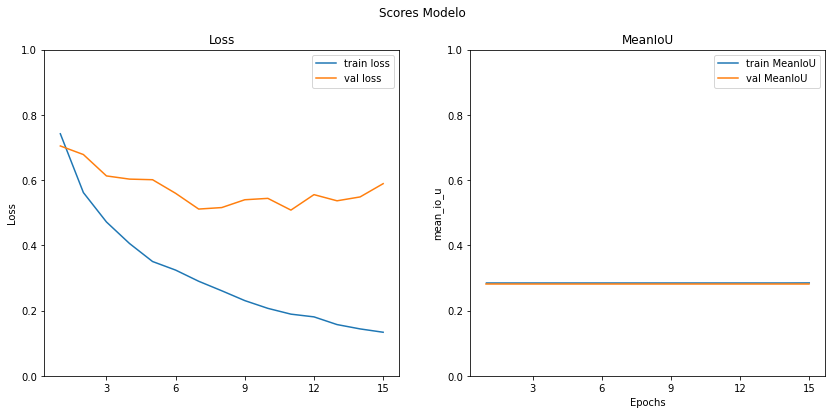

In [34]:
plot_history('Scores Modelo', history2, ['train', 'val'])